#Xây dựng hệ thống truy xuất hình ảnh với deep feature

In [30]:
import sklearn, pandas
import numpy as np

#Load tập dữ liệu CIFAR-10

Chúng ta sẽ sử dụng tạp dữ liệu đánh giá xếp hạng phổ biến trong thị giác máy tính là CIFAR-10.

(Chúng tôi đã giảm dữ liệu xuống còn 4 hạng mục = {'cat','bird','automobile','dog'}.)

Tập dữ liệu này đã được chia thành training set và test set. Trong ví dụ truy xuất đơn giản này, không có khái niệm "testing" nên chúng ta sẽ chỉ sử dụng dữ liệu huấn luyện (training).

In [31]:
image_train = pandas.read_csv('image_train_data.csv')
#image_test = pandas.read_csv('image_test_data.csv')

In [32]:
import itertools, io
def convert_features(img):
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.float16)
    stringbuf.close()
    return array
def variable_length_to_2d(series):
    return np.array(list(itertools.zip_longest(*series.values, fillvalue=0))).T
image_train['deep_np'] = image_train['deep_features'].map(convert_features)
train_data = variable_length_to_2d(image_train['deep_np'])

In [33]:
def convert_img(img):
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.uint8)
    stringbuf.close()
    return array
image_train['image_np'] = image_train['image_array'].map(convert_img)

#Tính deep feature cho các hình ảnh

2 dòng dưới đây cho phép tính các deep feature. Việc tính toán này sẽ tốn một chút thời gian nên chúng tôi đã tính và lưu kết quả như ở cột trong dữ liệu mà bạn load.

(Lưu ý: nếu bạn muốn tính các deep feature như vậy và có GPU trên máy, bạn nên dùng GPU cho phép Graphlab Create, sẽ giúp tác vụ này nhanh hơn đáng kể).

In [34]:
#deep_learning_model = graphlab.load_model('http://s3.amazonaws.com/GraphLab-Datasets/deeplearning/imagenet_model_iter45')
#image_train['deep_features'] = deep_learning_model.extract_features(image_train)

In [35]:
image_train.head()

,id,image,label,deep_features,image_array,deep_np,image_np
0,24,Height: 32 Width: 32,bird,[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 ...,[73 77 58 71 68 50 77 69 44 120 116 83 125 120...,"[0.2429, 1.096, 0.0, 0.3936, 0.0, 0.0, 11.9, 0...","[73, 77, 58, 71, 68, 50, 77, 69, 44, 120, 116,..."
1,33,Height: 32 Width: 32,cat,[0.525088 0 0 0 0 0 9.94829 0 0 0 0 0 1.01264 ...,[7 5 8 7 5 8 5 4 6 7 4 7 11 5 9 11 5 9 17 11 1...,"[0.525, 0.0, 0.0, 0.0, 0.0, 0.0, 9.945, 0.0, 0...","[7, 5, 8, 7, 5, 8, 5, 4, 6, 7, 4, 7, 11, 5, 9,..."
2,36,Height: 32 Width: 32,cat,[0.566016 0 0 0 0 0 9.9972 0 0 0 1.38345 0 0.7...,[169 122 65 131 108 75 193 196 192 218 221 222...,"[0.566, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0....","[169, 122, 65, 131, 108, 75, 193, 196, 192, 21..."
3,70,Height: 32 Width: 32,dog,[1.1298 0 0 0.778194 0 0.758051 9.83053 0 0 0....,[154 179 152 159 183 157 165 189 162 174 199 1...,"[1.13, 0.0, 0.0, 0.7783, 0.0, 0.758, 9.83, 0.0...","[154, 179, 152, 159, 183, 157, 165, 189, 162, ..."
4,90,Height: 32 Width: 32,bird,[1.71787 0 0 0 0 0 9.33936 0 0 0 0 0 0.412137 ...,[216 195 180 201 178 160 210 184 164 212 188 1...,"[1.718, 0.0, 0.0, 0.0, 0.0, 0.0, 9.336, 0.0, 0...","[216, 195, 180, 201, 178, 160, 210, 184, 164, ..."


#Huấn luyện mô hình nearest-neighbor cho việc truy xuất hình ảnh sử dụng các deep feature

Giờ chúng ta sẽ xây dựng một hệ thống truy xuất hình ảnh đơn giản giúp tìm nearest neighbor cho bất kỳ hình nào.



In [36]:
#knn_model = graphlab.nearest_neighbors.create(image_train,features=['deep_features'],
#                                             label='id')
from sklearn.neighbors import NearestNeighbors
knn_model = NearestNeighbors(metric='cosine')
knn_model.fit(train_data)

NearestNeighbors(metric='cosine')

#Sử dụng mô hình truy xuất hình ảnh với các deep feature để tìm các hình tương tự

Hãy tìm các hình ảnh tương tự với bức ảnh con mèo này.

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_image(image_data, dimension=(32, 32, 3)):
    image = np.reshape(image_data, dimension)
    plt.axis('off')
    plt.imshow(image)

def show_images(images, cols=3):
    rows = len(images) // cols + ( 0 if len(images) % cols == 0 else 1)
    fig = plt.figure(figsize=(cols, rows))
    for i, img_data in enumerate(images):
        #i_row, i_col = i % cols, i // cols
        fig.add_subplot(rows, cols, i+1)
        show_image(img_data)

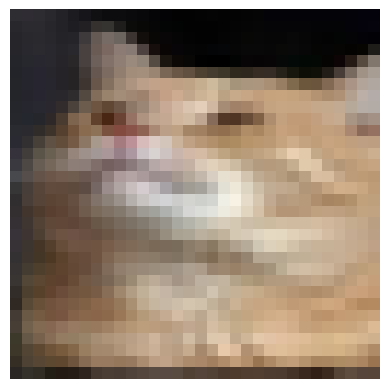

In [38]:
#graphlab.canvas.set_target('ipynb')
cat = image_train[18:19]
#print(cat['image_np'].values)
show_image(cat['image_np'].values[0])

In [39]:
# we want 5 closest, so 6 and remove itself
cat_neighbors = knn_model.kneighbors(variable_length_to_2d(cat['deep_np']), n_neighbors=6)[1][0][1:]

Chúng ta sẽ tạo một hàm đơn giản để xem các nearest neighbor và lưu những thứ đã nhập:

In [40]:
def get_data_from_ids(query_result):
    return image_train.iloc[query_result]
    #return image_train.filter_by(query_result['reference_label'],'id')

In [41]:
cat_neighbors_queried = get_data_from_ids(cat_neighbors)
cat_neighbors_queried

,id,image,label,deep_features,image_array,deep_np,image_np
1633,41734,Height: 32 Width: 32,cat,[0 0 0 0 0 0 11.6715 0 0 0 0 0 1.82079 0 0 0.5...,[122 27 34 120 24 31 119 21 29 120 19 28 121 1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.67, 0.0, 0.0...","[122, 27, 34, 120, 24, 31, 119, 21, 29, 120, 1..."
288,6910,Height: 32 Width: 32,cat,[1.55475 0 0 0 0 0 10.1923 0 0 0 0 0 0.793507 ...,[154 133 92 134 112 75 108 87 53 98 78 45 104 ...,"[1.555, 0.0, 0.0, 0.0, 0.0, 0.0, 10.195, 0.0, ...","[154, 133, 92, 134, 112, 75, 108, 87, 53, 98, ..."
1565,39777,Height: 32 Width: 32,cat,[0 0 0 0 0 0 9.42072 0 0 0 0 0 1.15609 0 0 0.9...,[145 166 165 164 185 184 185 206 205 198 218 2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.42, 0.0, 0.0,...","[145, 166, 165, 164, 185, 184, 185, 206, 205, ..."
1227,30402,Height: 32 Width: 32,bird,[1.49921 0 0 0 0 0 9.82078 0.0336478 0 0 0 0 2...,[124 114 111 109 105 102 86 84 80 73 71 64 81 ...,"[1.499, 0.0, 0.0, 0.0, 0.0, 0.0, 9.82, 0.03366...","[124, 114, 111, 109, 105, 102, 86, 84, 80, 73,..."
1468,36870,Height: 32 Width: 32,cat,[0.240483 0 0 0 0 0 9.52754 0 0 0 0 0 1.56046 ...,[16 20 19 14 19 17 11 15 14 9 15 13 14 21 20 2...,"[0.2405, 0.0, 0.0, 0.0, 0.0, 0.0, 9.53, 0.0, 0...","[16, 20, 19, 14, 19, 17, 11, 15, 14, 9, 15, 13..."


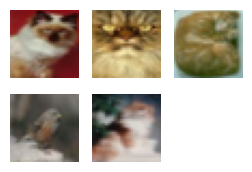

In [42]:
#cat_neighbors_queried['image']
show_images(cat_neighbors_queried['image_np'].values)

Các kết quả tuyệt vời cho ra các chú mèo tương tự.

##Tìm hình ảnh ô tô tương tự

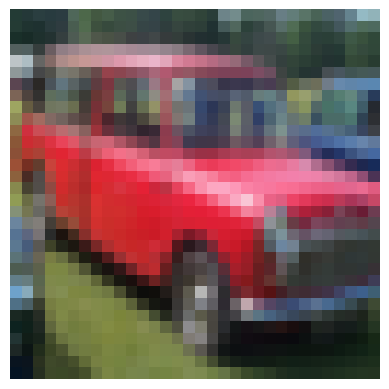

In [43]:
car = image_train[8:9]
show_image(car['image_np'].values[0])

In [44]:
car_neighbors = knn_model.kneighbors(variable_length_to_2d(car['deep_np']), n_neighbors=6)[1][0][1:]
#get_images_from_ids(car_neighbors)['image'].show()
get_data_from_ids(car_neighbors)

,id,image,label,deep_features,image_array,deep_np,image_np
372,8977,Height: 32 Width: 32,automobile,[0 0 0 0.136156 0 0 6.81498 0 0 0 0 0 0.437228...,[186 195 199 182 192 198 184 196 203 178 190 1...,"[0.0, 0.0, 0.0, 0.1361, 0.0, 0.0, 6.816, 0.0, ...","[186, 195, 199, 182, 192, 198, 184, 196, 203, ..."
1757,44395,Height: 32 Width: 32,automobile,[0 0 0 1.34758 0 0 7.38394 0 0 0 0 0 0.860271 ...,[89 95 50 83 84 43 69 70 42 64 69 39 55 63 29 ...,"[0.0, 0.0, 0.0, 1.348, 0.0, 0.0, 7.383, 0.0, 0...","[89, 95, 50, 83, 84, 43, 69, 70, 42, 64, 69, 3..."
1009,24146,Height: 32 Width: 32,automobile,[0 0 0 0 0 0 9.21664 0 0 0 0 0 0.291935 0 0 0....,[229 231 227 232 235 231 231 235 230 233 237 2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0,...","[229, 231, 227, 232, 235, 231, 231, 235, 230, ..."
1343,33261,Height: 32 Width: 32,automobile,[0 0 0 0 0 0.157148 6.90395 0 0 0 1.25121 0 0....,[110 118 104 98 104 80 92 100 68 95 110 60 112...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.1571, 6.902, 0.0, ...","[110, 118, 104, 98, 104, 80, 92, 100, 68, 95, ..."
1840,46240,Height: 32 Width: 32,automobile,[0 0.643995 0 0 0 0 6.92689 0 0 0 2.34283 0 1....,[161 186 232 155 174 211 142 165 206 153 179 2...,"[0.0, 0.644, 0.0, 0.0, 0.0, 0.0, 6.926, 0.0, 0...","[161, 186, 232, 155, 174, 211, 142, 165, 206, ..."


#Đùa chút thôi, hãy tạo một lambda để tìm và chỉ ra các hình tương tự nhất

In [45]:
def show_neighbors(idx, n_neighbors=5):
    neighbors = knn_model.kneighbors(train_data[idx:idx+1], n_neighbors=n_neighbors+1)[1][0][1:]
    neighbors_queried = get_data_from_ids(neighbors)
    return neighbors_queried

In [46]:
test_8 = show_neighbors(8)
test_8

,id,image,label,deep_features,image_array,deep_np,image_np
372,8977,Height: 32 Width: 32,automobile,[0 0 0 0.136156 0 0 6.81498 0 0 0 0 0 0.437228...,[186 195 199 182 192 198 184 196 203 178 190 1...,"[0.0, 0.0, 0.0, 0.1361, 0.0, 0.0, 6.816, 0.0, ...","[186, 195, 199, 182, 192, 198, 184, 196, 203, ..."
1757,44395,Height: 32 Width: 32,automobile,[0 0 0 1.34758 0 0 7.38394 0 0 0 0 0 0.860271 ...,[89 95 50 83 84 43 69 70 42 64 69 39 55 63 29 ...,"[0.0, 0.0, 0.0, 1.348, 0.0, 0.0, 7.383, 0.0, 0...","[89, 95, 50, 83, 84, 43, 69, 70, 42, 64, 69, 3..."
1009,24146,Height: 32 Width: 32,automobile,[0 0 0 0 0 0 9.21664 0 0 0 0 0 0.291935 0 0 0....,[229 231 227 232 235 231 231 235 230 233 237 2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0,...","[229, 231, 227, 232, 235, 231, 231, 235, 230, ..."
1343,33261,Height: 32 Width: 32,automobile,[0 0 0 0 0 0.157148 6.90395 0 0 0 1.25121 0 0....,[110 118 104 98 104 80 92 100 68 95 110 60 112...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.1571, 6.902, 0.0, ...","[110, 118, 104, 98, 104, 80, 92, 100, 68, 95, ..."
1840,46240,Height: 32 Width: 32,automobile,[0 0.643995 0 0 0 0 6.92689 0 0 0 2.34283 0 1....,[161 186 232 155 174 211 142 165 206 153 179 2...,"[0.0, 0.644, 0.0, 0.0, 0.0, 0.0, 6.926, 0.0, 0...","[161, 186, 232, 155, 174, 211, 142, 165, 206, ..."


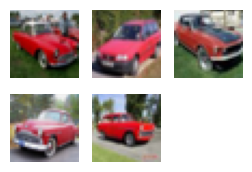

In [47]:
show_images(test_8['image_np'].values)

In [48]:
test_26 = show_neighbors(26)
test_26

,id,image,label,deep_features,image_array,deep_np,image_np
457,11000,Height: 32 Width: 32,automobile,[0 0.26031 0 0 0 0.23388 10.0011 0 0 0 0.18946...,[255 255 255 219 222 229 167 171 185 170 174 1...,"[0.0, 0.2603, 0.0, 0.0, 0.0, 0.2339, 10.0, 0.0...","[255, 255, 255, 219, 222, 229, 167, 171, 185, ..."
377,9118,Height: 32 Width: 32,automobile,[0.914692 0 0 0 0 0 9.96389 0 0 0 0.127803 0 2...,[107 117 133 98 107 114 113 121 120 124 128 12...,"[0.9146, 0.0, 0.0, 0.0, 0.0, 0.0, 9.96, 0.0, 0...","[107, 117, 133, 98, 107, 114, 113, 121, 120, 1..."
1576,40118,Height: 32 Width: 32,automobile,[0.3851 0.0709699 0 0 0 0 8.91591 0 0 0 0 0 0....,[157 145 124 154 143 121 163 147 123 163 144 1...,"[0.385, 0.071, 0.0, 0.0, 0.0, 0.0, 8.914, 0.0,...","[157, 145, 124, 154, 143, 121, 163, 147, 123, ..."
1280,31776,Height: 32 Width: 32,automobile,[0.767597 0.517459 0 0 0 0 9.75294 0 0 0 0.525...,[139 149 118 140 148 119 156 166 128 113 119 9...,"[0.7676, 0.5176, 0.0, 0.0, 0.0, 0.0, 9.75, 0.0...","[139, 149, 118, 140, 148, 119, 156, 166, 128, ..."
990,23662,Height: 32 Width: 32,automobile,[0.104303 0 0 0 0 0.804265 9.38957 0 0 0 0.052...,[176 175 172 174 174 169 179 179 175 165 166 1...,"[0.1043, 0.0, 0.0, 0.0, 0.0, 0.804, 9.39, 0.0,...","[176, 175, 172, 174, 174, 169, 179, 179, 175, ..."


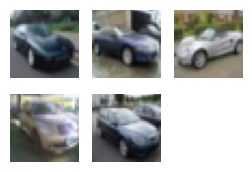

In [49]:
show_images(test_26['image_np'].values)

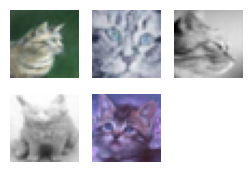

In [50]:
test_2=show_neighbors(2)
test_2
show_images(test_2['image_np'].values)
#show_images(test_26['image_np'].values)